# Inference

In [1]:
# External Libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import pandas as pd
import os
import scipy
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Internal Libs
from lib import networks, util, signal_utils
from lib.normalizer import DataNormalizer
from data.nsynth_loader import NSynth, to_one_hot

Loading Configuration JSON file

In [2]:
#option_name = 'ae_nsynth_recon5.json'
#option_name = 'ae_nsynth_recon5_2x1024x64.json'
#option_name = 'ae_nsynth_recon5_2x1024x64.json'
option_name = 'cae_nsynth_recon5_lat0.json'
option_path = os.path.join('./options/', option_name)

opt = util.load_json(option_path)
opt_train = opt['train']
opt_test = opt['test']
checkpoints_path = os.path.join(opt_train['checkpoints_dir'], opt['experiment_name'])
output_dir = os.path.join(checkpoints_path, opt_test['output_dir'])
util.mkdir(output_dir)
device = 'cuda:0'

Loading dataset loader

In [3]:
dataset = NSynth(opt)
data_norm = DataNormalizer(dataset, device)
datapath = os.path.join(dataset.root,'audio')
df = dataset.df
df.head()

Instruments families selected: ['mallet', 'string', 'brass', 'reed', 'flute']
WARNING. Normalization parameters are hardcoded!
p_a: 0.0034997
p_b: -0.010897
s_a: 0.060437
s_b: 0.034964


,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,file
17,85862,16000,75,0,string,string_acoustic_006,string_acoustic_006-075-025,"[bright, nonlinear_env, reverb]",acoustic,25,8,52,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0]",string_acoustic_006-075-025
19,35953,16000,65,0,reed,reed_acoustic_041,reed_acoustic_041-065-127,[reverb],acoustic,127,7,427,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",reed_acoustic_041-065-127
20,30131,16000,67,0,flute,flute_acoustic_030,flute_acoustic_030-067-100,[],acoustic,100,2,744,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",flute_acoustic_030-067-100
26,55879,16000,56,0,string,string_acoustic_075,string_acoustic_075-056-050,"[fast_decay, percussive, reverb]",acoustic,50,8,623,"[0, 0, 0, 1, 0, 0, 0, 1, 1, 0]",string_acoustic_075-056-050
27,60247,16000,41,0,string,string_acoustic_069,string_acoustic_069-041-050,"[long_release, nonlinear_env, reverb]",acoustic,50,8,580,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0]",string_acoustic_069-041-050


Loading network and parameters for both encoder and decoder 

In [4]:
encoder = networks.instantiate_encoder(opt).to(device)
decoder = networks.instantiate_decoder(opt).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
encoder.load_state_dict(torch.load(os.path.join(snap_path, '50_Enc.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(snap_path, '50_Dec.pth'), map_location=device))

<All keys matched successfully>

Loading network and parameters for autoencoder

In [ ]:
autoencoder = networks.instantiate_autoencoder(opt).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
autoencoder.load_state_dict(torch.load(os.path.join(snap_path, 'latest_AE.pth'), map_location=device))

### Helper Functions

In [5]:
def generate(data, pitch=None):
    if pitch is not None:
        #decoded_feat = decoder(latent, to_one_hot(128, pitch).unsqueeze(0).to(device))
        decoded_feat, latent = autoencoder(data, to_one_hot(128, pitch).unsqueeze(0).to(device))
    else:
        #decoded_feat = decoder(latent)
        decoded_feat, latent = autoencoder(data)
    decoded_feat = decoded_feat.squeeze().cpu().detach().numpy()
    return reconstruct(decoded_feat[0,:,:],decoded_feat[1,:,:]), latent

def interpolate(data_1, data_2, pitch, alpha=0.5):
    latent_1, skip_1 = autoencoder.encode(data_norm.normalize(data_1))
    #latent_1 = encoder(data_norm.normalize(data_1))
    latent_2, skip_2 = autoencoder.encode(data_norm.normalize(data_2))
    #latent_2 = encoder(data_norm.normalize(data_2))
    
    latent = latent_1 * alpha + (1-alpha) * latent_2
    
    #decoded_feat = autoencoder.decoder(latent, to_one_hot(128, pitch).unsqueeze(0).to(device))
    decoded_feat = autoencoder.decode(latent, skip_1)
    decoded_feat = decoded_feat.squeeze().cpu().detach().numpy()
    return reconstruct(decoded_feat[0,:,:],decoded_feat[1,:,:])

def arrange_data(sample):
    sample = sample.astype(np.float)
    logmel, mel_phase = dataset.compute_features(sample)
    logmel = torch.from_numpy(logmel).float()
    mel_phase = torch.from_numpy(mel_phase).float()
    logmel = logmel.unsqueeze(0)
    mel_phase = mel_phase.unsqueeze(0)

    data = torch.cat([logmel, mel_phase], dim = 0)
    data = data.unsqueeze(0).to(device) # Batch dim
    return data

def reconstruct(spec, IF):
    #spec, IF = data_norm.denormalize(spec, IF, s_a=0.060437, s_b=0.034964, p_a=0.0034997, p_b=-0.010897)
    spec = data_norm.denormalize(spec, s_a=0.060437, s_b=0.034964)
    spec = data_norm.denormalize_IF(IF, p_a=0.0034997, p_b=-0.010897)
    spec, IF = signal_utils.melspecgrams_to_specgrams(spec, IF)
    spec = np.vstack((spec,spec[1023]))
    IF = np.vstack((IF,IF[1023]))
    
    spec =  np.exp(spec) - 1.0e-6
    reconstruct_magnitude = np.abs(spec)

    reconstruct_phase_angle = np.cumsum(IF * np.pi, axis=1)
    stft = polar2rect(reconstruct_magnitude, reconstruct_phase_angle)
    audio = librosa.istft(stft, hop_length = 512, win_length=2048, window = 'hann')
    return audio

def polar2rect(mag, phase_angle):
    """Convert polar-form complex number to its rectangular form."""
    temp_mag = np.zeros(mag.shape,dtype=np.complex_)
    temp_phase = np.zeros(mag.shape,dtype=np.complex_)

    for i, time in enumerate(mag):
        for j, time_id in enumerate(time):
            temp_mag[i,j] = np.complex(mag[i,j])

    for i, time in enumerate(phase_angle):
        for j, time_id in enumerate(time):
            temp_phase[i,j] = np.complex(np.cos(phase_angle[i,j]), np.sin(phase_angle[i,j]))
    return temp_mag * temp_phase

def export_audio(sample, path, rate= 16000):
    scipy.io.wavfile.write(path, rate, sample)

def plot_spectrogram(sample):
    sample = sample.astype(np.float)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sample)), ref=np.max)
    librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')

def scatter_fuzzy(x, y, method='pca', export=False, title='', colormap = 'winter'): #hsv for multiple colormap
    if method == 'pca':
        pca = PCA(2)
        projection = pca.fit_transform(x)
    elif method == 't-sne':
        projection = TSNE(random_state=123).fit_transform(x)        
    fig, ax = plt.subplots(1,1, figsize=(7, 7))
    plot = ax.scatter(projection[:, 0], projection[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap(colormap, len(np.unique(y))))
    fig.colorbar(plot, ax=ax, orientation='vertical')

def scatter_labels(x,y, method='pca', export=False, title='', color_labels= None): #colormap = 'winter'
    if method == 'pca':
        pca = PCA(2)
        projection = pca.fit_transform(x)
    elif method == 't-sne':
        projection = TSNE(random_state=123).fit_transform(x)
    colors = plt.cm.rainbow(np.linspace(0,1,len(np.unique(y))))
    fig, ax = plt.subplots(figsize = (7,7))
    for idx, color_id in enumerate(np.unique(y)):
        ix = np.where(y == color_id)
        if color_labels is not None:
            ax.scatter(projection[ix][:,0], projection[ix][:,1], 
                        c = colors[idx], label = color_labels[color_id], s=3)
        else:
            ax.scatter(projection[ix][:,0], projection[ix][:,1], 
                        c = colors[idx], label = color_id)            
    ax.legend(markerscale=4.,scatterpoints=1)
    plt.show()

# EDA

Simple Auto-Encoder latent representation.

In [6]:
emb_list = []
pitch_label = []
instr_label = []
total_iter = 2000
for idx, data in enumerate(dataset):
    data['src_data'] = data_norm.normalize(data['src_data'].to(device))
    data['trg_data'] = data_norm.normalize(data['trg_data'].to(device))
    
    latent, _ = autoencoder.encode(data['src_data'])
    
    emb_list.append(latent.squeeze().cpu().detach().numpy())
    pitch_label.append(torch.argmax(data['src_pitch'], dim=0, keepdims=False).numpy())
    instr_label.append(data['src_instr'].numpy())
    if idx % 100 == 0:
        print('{} samples...'.format(idx))
    if idx >= total_iter-1:
        print('{} samples have been Encoded/Decoded'.format(idx))
        break
x = np.stack(emb_list,axis=0)
y_pitch = np.array(pitch_label)
y_instr = np.array(instr_label)

0 samples...
100 samples...
200 samples...
300 samples...
400 samples...
500 samples...
600 samples...
700 samples...
800 samples...
900 samples...
1000 samples...
1100 samples...
1200 samples...
1300 samples...
1400 samples...
1500 samples...
1600 samples...
1700 samples...
1800 samples...
1900 samples...
1999 samples have been Encoded/Decoded


In [7]:
color_labels = {1 :'brass', 2:'flute', 5 : 'mallet', 7 :'reed', 8 : 'string'}

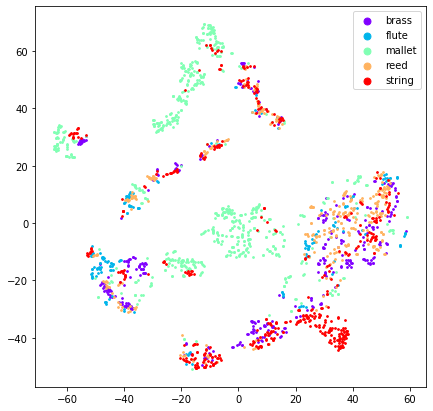

In [8]:
scatter_labels(x, y_instr, 't-sne', color_labels = color_labels)

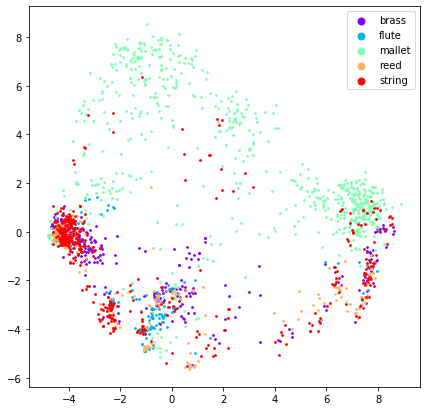

In [9]:
scatter_labels(x, y_instr, 'pca', color_labels = color_labels)

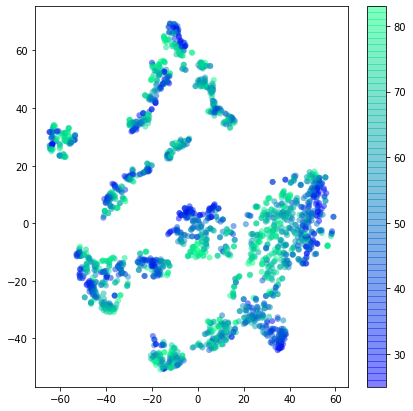

In [10]:
scatter_fuzzy(x, y_pitch, 't-sne')

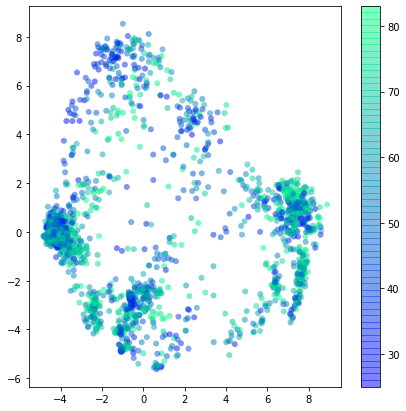

In [11]:
scatter_fuzzy(x, y_pitch, 'pca')

### Pitch Control

First we select and load a sample from the dataset.

In [32]:
#sample_name = 'string_acoustic_022-040-025' #= df.iloc[61]['file']
sample_name = 'string_acoustic_022-040-025'
_, sample = scipy.io.wavfile.read(os.path.join(datapath, sample_name + '.wav'))
ipd.Audio(sample, rate=16000)

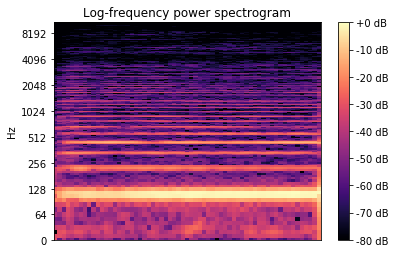

In [33]:
plot_spectrogram(sample)

Preparing data

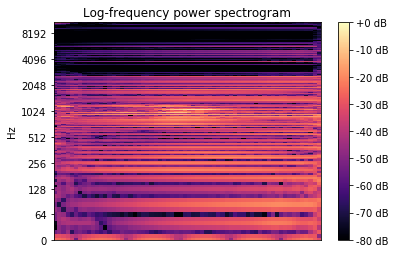

In [35]:
data = arrange_data(sample)
aud_recon = generate(data)[0] # generate(data, 40)[0] 
plot_spectrogram(aud_recon)
ipd.Audio(aud_recon, rate=16000)

Scale Generation

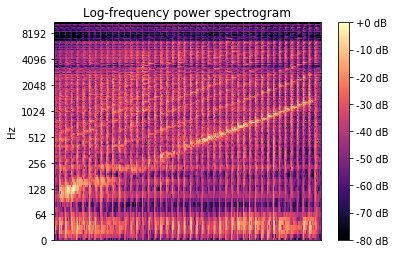

In [95]:
list_audio = []
for i in range(40,85):
    ad = generate(data, i)[0]
    ad = ad[:6000]
    list_audio.append(ad)
list_audio = np.hstack(list_audio)
plot_spectrogram(list_audio)
ipd.Audio(list_audio, rate=16000)

In [86]:
export_audio(list_audio, os.path.join(output_dir, 'noclass_flute_scale'))

### Timbre Interpolation

In [182]:
sample_1_name = 'string_acoustic_022-050-050'
_, sample_1 = scipy.io.wavfile.read(os.path.join(datapath, sample_1_name + '.wav'))
ipd.Audio(sample, rate=16000)

In [183]:
sample_2_name = 'flute_acoustic_003-050-050'
_, sample_2 = scipy.io.wavfile.read(os.path.join(datapath, sample_2_name + '.wav'))
ipd.Audio(sample_2, rate=16000)

In [154]:
data_1 = arrange_data(sample_1)
data_2 = arrange_data(sample_2)
interp = interpolate(data_1, data_2, 50, 0)

In [155]:
ipd.Audio(interp, rate=16000)

# References

Visualization
- https://www.datacamp.com/community/tutorials/introduction-t-sne
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
